In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
import shutil
from sklearn.utils import shuffle

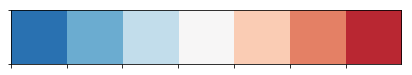

In [4]:
import seaborn as sns
sns.palplot(sns.color_palette("RdBu_r", 7))

sns.set_style("whitegrid")

# Importando base de dados

<p>Base com todos os dados do sudeste</p>

In [5]:
df = pd.read_csv('../data/sudeste.csv',low_memory=False)
print len(df)

9779168


<p>Base com todas chuvas EXTREMAS com inicio e fim de cada chuva extrema (> 50mm em 24 horas)</p>

In [6]:
dfhr = pd.read_csv('../data/extreme_prcp_evolution.csv')
print len(dfhr)

31710


<p>Subconjunto da base principal considerando o inicio e fim das chuvas extremas (> 50mm em 24 horas)</p>

In [7]:
dfext = pd.read_csv('../data/sudeste_extreme_prcp.csv', index_col=0)
print len(dfext)

101976


# Pré-processamento

<h3>Limpeza dos dados</h3>

In [8]:
# Campos não numericos e campos derivados
DES= ['wsid','wsnm','elvt','lat','lon','inme','city','prov']
INT = ['yr','mo','da','hr']
DAT = ['mdct','date']
DER = ['smax','smin','tmax','tmin','dmax','dmin','hmax','hmin']

In [9]:
# dataframe apenas com os dados continuos
dfcont = df
for f in DES + INT + DAT:    
    dfcont = dfcont.drop(f, 1)

In [10]:
dfcont = dfcont.apply(pd.to_numeric, errors='coerce')  

In [11]:
dfcont.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9779168 entries, 0 to 9779167
Data columns (total 17 columns):
prcp    float64
stp     float64
smax    float64
smin    float64
gbrd    float64
temp    float64
tmax    float64
tmin    float64
dewp    float64
dmax    float64
dmin    float64
hmdy    float64
hmax    float64
hmin    float64
wdsp    float64
wdct    float64
gust    float64
dtypes: float64(17)
memory usage: 1.2 GB


In [12]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,1407984.0,0.936654,2.923291,0.0,0.0,0.000,0.6,100.000
stp,9779168.0,880.429177,248.264986,0.0,911.3,944.200,973.1,1050.000
smax,9779168.0,880.303394,248.917148,0.0,911.5,944.400,973.3,1050.000
smin,9779168.0,879.833097,248.771557,0.0,911.0,943.900,972.8,1050.000
gbrd,5670348.0,1176.371062,1138.753521,0.0,65.0,863.427,2103.0,11586.491
temp,9779137.0,20.474225,7.331125,-3.8,17.7,21.400,24.9,44.900
tmax,9778693.0,14.726810,5.805413,-10.0,12.1,16.100,18.9,42.700
tmin,9779142.0,21.105026,7.545549,-3.2,18.2,21.900,25.8,45.000
dewp,9778858.0,15.240249,5.866811,-10.0,12.7,16.600,19.4,44.800
dmax,9779134.0,19.864175,7.134849,-8.5,17.2,20.800,24.2,45.000


<p> A variável gbbr(radiação global) apresenta massivamente números nulos e não pode ser recuperada. Vamos retirar esta variável.</p>

In [13]:
dfcont =  dfcont.drop('gbrd',1)
df = df.drop('gbrd',1)

<p>Para as precipitações nulas foi inputado 0.0 mm. Também para o vento e rajada de vento.</p>

In [14]:
CAN_BE_NULL = ['wdsp','prcp','gust']

In [15]:
for v in CAN_BE_NULL:
    df[v] = df[v].fillna(0.0)
    dfcont[v] = dfcont[v].fillna(0.0)  

<p>Vamos ver como os dados contínuos estão organizados: MÍNIMOS, MÁXIMOS, MEDIAS</p>

In [16]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,9779168.0,0.134858,1.156940,0.0,0.0,0.0,0.0,100.0
stp,9779168.0,880.429177,248.264986,0.0,911.3,944.2,973.1,1050.0
smax,9779168.0,880.303394,248.917148,0.0,911.5,944.4,973.3,1050.0
smin,9779168.0,879.833097,248.771557,0.0,911.0,943.9,972.8,1050.0
temp,9779137.0,20.474225,7.331125,-3.8,17.7,21.4,24.9,44.9
tmax,9778693.0,14.726810,5.805413,-10.0,12.1,16.1,18.9,42.7
tmin,9779142.0,21.105026,7.545549,-3.2,18.2,21.9,25.8,45.0
dewp,9778858.0,15.240249,5.866811,-10.0,12.7,16.6,19.4,44.8
dmax,9779134.0,19.864175,7.134849,-8.5,17.2,20.8,24.2,45.0
dmin,9778361.0,14.220885,5.777089,-10.0,11.6,15.6,18.4,44.9


<p>A temperatura será inputada pela média</p>

In [17]:
MEAN = ['temp','dewp']

In [18]:
for v in MEAN:
    df[v] = df[v].fillna(value=df[v].median())
    dfcont[v] = dfcont[v].fillna(value=dfcont[v].median())

In [19]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,9779168.0,0.134858,1.156940,0.0,0.0,0.0,0.0,100.0
stp,9779168.0,880.429177,248.264986,0.0,911.3,944.2,973.1,1050.0
smax,9779168.0,880.303394,248.917148,0.0,911.5,944.4,973.3,1050.0
smin,9779168.0,879.833097,248.771557,0.0,911.0,943.9,972.8,1050.0
temp,9779168.0,20.474228,7.331113,-3.8,17.7,21.4,24.9,44.9
tmax,9778693.0,14.726810,5.805413,-10.0,12.1,16.1,18.9,42.7
tmin,9779142.0,21.105026,7.545549,-3.2,18.2,21.9,25.8,45.0
dewp,9779168.0,15.240292,5.866723,-10.0,12.7,16.6,19.4,44.8
dmax,9779134.0,19.864175,7.134849,-8.5,17.2,20.8,24.2,45.0
dmin,9778361.0,14.220885,5.777089,-10.0,11.6,15.6,18.4,44.9


In [20]:
for v in ['tmax','tmin']:
    dfcont[v] = dfcont[v].fillna(value=dfcont['temp'])
    df[v] = df[v].fillna(value=df['temp'])
for v in ['dmax','dmin']:
    dfcont[v] = dfcont[v].fillna(value=dfcont['dewp'])
    df[v] = df[v].fillna(value=df['dewp'])
for v in ['hmax','hmin']:
    dfcont[v] = dfcont[v].fillna(value=dfcont['hmdy'])
    df[v] = df[v].fillna(value=df['hmdy'])

In [21]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,9779168.0,0.134858,1.156940,0.0,0.0,0.0,0.0,100.0
stp,9779168.0,880.429177,248.264986,0.0,911.3,944.2,973.1,1050.0
smax,9779168.0,880.303394,248.917148,0.0,911.5,944.4,973.3,1050.0
smin,9779168.0,879.833097,248.771557,0.0,911.0,943.9,972.8,1050.0
temp,9779168.0,20.474228,7.331113,-3.8,17.7,21.4,24.9,44.9
tmax,9779168.0,14.727113,5.805794,-10.0,12.1,16.1,18.9,42.7
tmin,9779168.0,21.104973,7.545616,-3.2,18.2,21.9,25.8,45.0
dewp,9779168.0,15.240292,5.866723,-10.0,12.7,16.6,19.4,44.8
dmax,9779168.0,19.864112,7.134923,-8.5,17.2,20.8,24.2,45.0
dmin,9779168.0,14.219949,5.777816,-10.0,11.6,15.6,18.4,44.9


<h3>Derivando novas variáveis</h3>

<p>O objetivo é derivar cada variável climática contínua em uma nova variável t-1, t-2, t-3... t-n, onde n é o numeros de horas antes do momento t. Vamos primeiramente derivá-las para depois verificar quais quando massivamente as variávies estão zeradas, o que pode indicar que a estação falhou.</p>

<p>Utilizando um exemplo especifico de uma estação, depois verificamos o conjunto maior</p> 

In [22]:
dfm = df[(df.wsid==329)]
len(dfm)

87456

In [23]:
dfm.index = pd.to_datetime(dfm.mdct)
dfm.head(4)

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
mdct,,,,,,,,,,,,,,,,,,,,,
2006-10-10 00:00:00,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-10-10 00:00:00,2006-10-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 01:00:00,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-10-10 01:00:00,2006-10-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 02:00:00,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-10-10 02:00:00,2006-10-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 03:00:00,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-10-10 03:00:00,2006-10-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
CLEAN = ['wsnm','inme','city','prov','mdct','date']
REMOVE = ['wsid','yr', 'mo', 'da', 'hr']
for v in CLEAN + REMOVE:
    dfm = dfm.drop(v,1)
dfm.head(5)  

,elvt,lat,lon,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
mdct,,,,,,,,,,,,,,,,,,,
2006-10-10 00:00:00,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 01:00:00,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 02:00:00,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 03:00:00,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 04:00:00,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
def derive_nth_hour_feature(df, feature, N):  
    rows = df.shape[0]
    nth_prior_measurements = [None]*N + [df[feature][i-N] for i in range(N, rows)]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = np.nan
    df.loc[:][col_name] = nth_prior_measurements

In [26]:
NON_DER = ['wsid','elvt','lat', 'lon', 'yr', 'mo', 'da', 'hr']

for feature in dfm.columns:
    if feature not in NON_DER:
        for h in range(1,6):
            derive_nth_hour_feature(dfm, feature, h) 

In [27]:
REMOVE = [u'prcp_1', u'prcp_2', u'prcp_3', u'prcp_4', u'prcp_5']
for v in REMOVE:
    dfm = dfm.drop(v,1)

In [28]:
dfm.columns

Index([u'elvt', u'lat', u'lon', u'prcp', u'stp', u'smax', u'smin', u'temp',
       u'tmax', u'tmin', u'dewp', u'dmax', u'dmin', u'hmdy', u'hmax', u'hmin',
       u'wdsp', u'wdct', u'gust', u'stp_1', u'stp_2', u'stp_3', u'stp_4',
       u'stp_5', u'smax_1', u'smax_2', u'smax_3', u'smax_4', u'smax_5',
       u'smin_1', u'smin_2', u'smin_3', u'smin_4', u'smin_5', u'temp_1',
       u'temp_2', u'temp_3', u'temp_4', u'temp_5', u'tmax_1', u'tmax_2',
       u'tmax_3', u'tmax_4', u'tmax_5', u'tmin_1', u'tmin_2', u'tmin_3',
       u'tmin_4', u'tmin_5', u'dewp_1', u'dewp_2', u'dewp_3', u'dewp_4',
       u'dewp_5', u'dmax_1', u'dmax_2', u'dmax_3', u'dmax_4', u'dmax_5',
       u'dmin_1', u'dmin_2', u'dmin_3', u'dmin_4', u'dmin_5', u'hmdy_1',
       u'hmdy_2', u'hmdy_3', u'hmdy_4', u'hmdy_5', u'hmax_1', u'hmax_2',
       u'hmax_3', u'hmax_4', u'hmax_5', u'hmin_1', u'hmin_2', u'hmin_3',
       u'hmin_4', u'hmin_5', u'wdsp_1', u'wdsp_2', u'wdsp_3', u'wdsp_4',
       u'wdsp_5', u'wdct_1', u'wdct_2', u'

In [29]:
dfm = dfm.reset_index(drop=True)

In [30]:
dfm = dfm.dropna()  

In [31]:
dfm.head(5)

,elvt,lat,lon,prcp,stp,smax,smin,temp,tmax,tmin,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
5,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# como esta rede é especifica para a BH, vamos remover elvt, lat, lon
REMOVE = ['elvt','lat', 'lon']
for v in REMOVE:
    dfm = dfm.drop(v,1)

In [33]:
dfm.head(5)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
CAN_BE_NULL

['wdsp', 'prcp', 'gust']

<h3>Preparando a base</h3>

<p>Removendo registros que não pode ser nulos e prejudicariam o treinamento</p>

In [35]:
cols = list(dfm.columns)

COLS_BE_NULL = ['prcp','wdsp','wdsp_1','wdsp_2','wdsp_3','wdsp_4','wdsp_5',\
                'gust','gust_1','gust_2','gust_3','gust_4','gust_5']
for v in COLS_BE_NULL:
    cols.remove(v)

In [36]:
dfm[cols] = dfm[cols].replace({0.0:np.nan})
dfm.head(5)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0


In [37]:
dfm = dfm.dropna()

In [38]:
len(dfm)

86007

In [39]:
dfm.head(5)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
19,0.0,922.0,922.2,922.0,21.4,14.2,22.0,15.0,21.3,13.7,...,59.0,61.0,69.0,98.0,75.0,6.9,8.0,7.3,8.8,8.8
20,0.0,922.1,922.2,922.0,20.7,14.8,21.4,14.9,20.7,14.2,...,118.0,59.0,61.0,69.0,98.0,7.5,6.9,8.0,7.3,8.8
21,0.0,921.9,922.1,921.8,20.3,14.9,20.8,15.1,20.3,14.7,...,108.0,118.0,59.0,61.0,69.0,7.7,7.5,6.9,8.0,7.3
22,0.0,921.6,922.1,921.6,20.1,14.2,20.4,15.0,20.0,14.2,...,118.0,108.0,118.0,59.0,61.0,7.6,7.7,7.5,6.9,8.0
23,0.0,921.8,921.8,921.5,19.8,13.9,20.2,14.2,19.8,13.7,...,102.0,118.0,108.0,118.0,59.0,7.3,7.6,7.7,7.5,6.9


In [40]:
dfm.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,86007.0,0.200865,1.632529,0.0,0.0,0.0,0.0,78.4
stp,86007.0,919.116980,3.190611,906.5,916.9,919.0,921.2,931.4
smax,86007.0,919.358709,3.171215,906.7,917.2,919.2,921.5,931.5
smin,86007.0,918.874314,3.199579,906.4,916.7,918.7,921.0,931.2
temp,86007.0,21.897662,3.927088,8.1,19.2,21.6,24.6,37.0
tmax,86007.0,14.566931,3.529708,-6.3,12.2,15.0,17.4,25.5
tmin,86007.0,22.572387,4.097611,8.7,19.7,22.2,25.5,37.7
dewp,86007.0,15.120801,3.520662,-1.7,12.7,15.6,17.9,23.6
dmax,86007.0,21.243377,3.753360,7.4,18.8,21.0,23.8,35.1
dmin,86007.0,14.039955,3.583685,-6.5,11.7,14.5,16.9,21.6


<h3>Balanceamento</h3>

<p>Preparação para o balanceamento</p>

In [41]:
from imblearn.over_sampling import SMOTE

In [171]:
def f(x):
    if x['prcp'] == 0.0: 
        return 0
    else: 
        return 1
dfm['type'] = dfm.apply(f, axis=1)
dfm.head()

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5,type
19,0.0,922.0,922.2,922.0,21.4,14.2,22.0,15.0,21.3,13.7,...,61.0,69.0,98.0,75.0,6.9,8.0,7.3,8.8,8.8,0
20,0.0,922.1,922.2,922.0,20.7,14.8,21.4,14.9,20.7,14.2,...,59.0,61.0,69.0,98.0,7.5,6.9,8.0,7.3,8.8,0
21,0.0,921.9,922.1,921.8,20.3,14.9,20.8,15.1,20.3,14.7,...,118.0,59.0,61.0,69.0,7.7,7.5,6.9,8.0,7.3,0
22,0.0,921.6,922.1,921.6,20.1,14.2,20.4,15.0,20.0,14.2,...,108.0,118.0,59.0,61.0,7.6,7.7,7.5,6.9,8.0,0
23,0.0,921.8,921.8,921.5,19.8,13.9,20.2,14.2,19.8,13.7,...,118.0,108.0,118.0,59.0,7.3,7.6,7.7,7.5,6.9,0


<h2>Mineiração dos dados</h2>

<h3>Rede neural</h3>

In [172]:
import tensorflow as tf  
from sklearn.metrics import explained_variance_score, mean_absolute_error,  median_absolute_error
from sklearn.model_selection import train_test_split  

In [183]:
target = 'prcp'

In [192]:
z = dfm['type'].groupby(dfm['type']).count()
print (z)

type
0    80270
1     5737
Name: type, dtype: int64


In [193]:
X = dfm[[col for col in dfm.columns if col != target]]

In [194]:
y = dfm[target]

In [195]:
X.head(5)

,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,...,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5,type
19,922.0,922.2,922.0,21.4,14.2,22.0,15.0,21.3,13.7,64.0,...,61.0,69.0,98.0,75.0,6.9,8.0,7.3,8.8,8.8,0
20,922.1,922.2,922.0,20.7,14.8,21.4,14.9,20.7,14.2,69.0,...,59.0,61.0,69.0,98.0,7.5,6.9,8.0,7.3,8.8,0
21,921.9,922.1,921.8,20.3,14.9,20.8,15.1,20.3,14.7,71.0,...,118.0,59.0,61.0,69.0,7.7,7.5,6.9,8.0,7.3,0
22,921.6,922.1,921.6,20.1,14.2,20.4,15.0,20.0,14.2,69.0,...,108.0,118.0,59.0,61.0,7.6,7.7,7.5,6.9,8.0,0
23,921.8,921.8,921.5,19.8,13.9,20.2,14.2,19.8,13.7,69.0,...,118.0,108.0,118.0,59.0,7.3,7.6,7.7,7.5,6.9,0


<p>Separando o conjunto de treinamento e validação</p>

In [196]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3, random_state=12) 

In [189]:
sm = SMOTE(random_state=12)

In [190]:
print (len(X_train),len(y_train))

(60204, 60204)


In [191]:
X_train, y_train = sm.fit_sample(X_train, y_train)

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 4, n_neighbors = 6

<p>Separando o conjunto de testes (metade dos 30% separados para validação)</p>

In [53]:
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5)

In [54]:
X_train.shape, X_test.shape, X_val.shape  
print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))  
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))  
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1]))  

Training instances   8031, Training features   90
Validation instances 1722, Validation features 90
Testing instances    1721, Testing features    90


In [55]:
# Zarate instructions
st_units = (X_train.shape[1] * 2) + 1
sd_units = X_train.shape[1] 
#activation_fn = tf.sigmoid
batch_size = 500

In [56]:
feature_cols = [tf.feature_column.numeric_column(col) for col in X.columns] 

In [57]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols,  
                                      hidden_units=[st_units,sd_units],
                                     # activation_fn=activation_fn,
                                      model_dir='/tmp/tf_wx_model-9')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x10d4bdbd0>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tf_wx_model-9', '_save_summary_steps': 100}


In [58]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=batch_size):  
    return tf.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [59]:
evaluations = []  
STEPS = 500  
for i in range(1, 100):  
    regressor.train(input_fn=wx_input_fn(X_train, y=y_train), steps=STEPS)
    evaluations.append(regressor.evaluate(input_fn=wx_input_fn(X_val,
                                                               y_val,
                                                               num_epochs=1,
                                                               shuffle=False)))

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-9/model.ckpt-500
INFO:tensorflow:Saving checkpoints for 501 into /tmp/tf_wx_model-9/model.ckpt.
INFO:tensorflow:loss = 16989.855, step = 501
INFO:tensorflow:global_step/sec: 22.1984
INFO:tensorflow:loss = 19204.555, step = 601 (4.506 sec)
INFO:tensorflow:global_step/sec: 23.1557
INFO:tensorflow:loss = 17316.375, step = 701 (4.319 sec)
INFO:tensorflow:global_step/sec: 22.8948
INFO:tensorflow:loss = 11568.209, step = 801 (4.368 sec)
INFO:tensorflow:global_step/sec: 22.9867
INFO:tensorflow:loss = 16786.588, step = 901 (4.350 sec)
INFO:tensorflow:Saving checkpoints for 1000 into /tmp/tf_wx_model-9/model.ckpt.


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt  
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 10]

loss_values = [ev['loss'] for ev in evaluations]  
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)  
plt.xlabel('Training steps')  
plt.ylabel('Loss (SSE)')  
plt.show()  

In [ ]:
pred = regressor.predict(input_fn=wx_input_fn(X_test,  
                                              num_epochs=1,
                                              shuffle=False))

predictions = np.array([p['predictions'][0] for p in pred])

In [ ]:

print("The Explained Variance: %.2f" % explained_variance_score(  
                                            y_test, predictions))  
print("The Mean Absolute Error: %.2f mm " % mean_absolute_error(  
                                            y_test, predictions))  
print("The Median Absolute Error: %.2f mm" % median_absolute_error(  
                                            y_test, predictions))

In [ ]:
predictions

In [ ]:
predictions.size

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()